# Data Analytics project - prediction of electric current prices

### Libraries

In [75]:
import datetime
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import time
from typing import List

from cmdstanpy import CmdStanModel
from sklearn.metrics import mean_squared_error
import seaborn as sns

### Importing data

#### Data 2019

In [76]:
df_ceny: pd.DataFrame = pd.read_csv("../Data/Prices/PL_CENY_NIEZB_RB_20190301_20190331.csv", sep=";", decimal=",")
df_zapotrzebowanie: pd.DataFrame = pd.read_csv("../Data/Load/PL_WYK_KSE_20190301_20190331.csv", encoding="cp1250", sep=";", decimal=",")
df_ceny["Data_i_Godzina"] = df_ceny["Data"].astype(str) + " " + (df_ceny["Godzina"] - 1).astype(str)  # Hours 1-24, changed into 0-23
df_ceny["Data_i_Godzina"] = df_ceny["Data_i_Godzina"].apply(datetime.datetime.strptime, args=("%Y%m%d %H",))
df_ceny = df_ceny[["Data", "Godzina", "Data_i_Godzina", "CRO"]]
df_zapotrzebowanie["Data_i_Godzina"] = df_zapotrzebowanie["Data"].astype(str) + " " + (df_zapotrzebowanie["Godzina"] - 1).astype(str) # Hours 1-24, changed into 0-23
df_zapotrzebowanie["Data_i_Godzina"] = df_zapotrzebowanie["Data_i_Godzina"].apply(datetime.datetime.strptime, args=("%Y-%m-%d %H",))
df_zapotrzebowanie["Dzień tygodnia"] = df_zapotrzebowanie["Data"].astype(str).apply(lambda x: pd.Timestamp(x).day_of_week)
df_list: List[pd.DataFrame] = []
df_naslonecznienie_temp: pd.DataFrame
for file in os.listdir("../Data/Weather2019"):
    df_naslonecznienie_temp = pd.read_csv(f"../Data/Weather2019/{file}", header=6, skipfooter=11, engine="python")
    df_naslonecznienie_temp = df_naslonecznienie_temp.loc[:, ["time", "G(i)", "T2m", "WS10m"]]
    df_naslonecznienie_temp["time"] = df_naslonecznienie_temp["time"].apply(str.__getitem__, args=(slice(None, -2, None),))
    df_naslonecznienie_temp["time"] = df_naslonecznienie_temp["time"].apply(datetime.datetime.strptime, args=("%Y%m%d:%H",))
    df_list.append(df_naslonecznienie_temp)
df_naslonecznienie: pd.DataFrame = pd.concat(df_list)
df_naslonecznienie = df_naslonecznienie.groupby("time").mean().reset_index()
df_naslonecznienie_marzec = df_naslonecznienie.loc[
    df_naslonecznienie["time"].between(datetime.datetime(2019, 3, 1), datetime.datetime(2019, 4, 1), inclusive="left")
    ]
df_naslonecznienie_marzec.reset_index(inplace=True)


#### Data 2020

In [77]:
df_ceny2020: pd.DataFrame = pd.read_csv("../Data/Prices/PL_CENY_NIEZB_RB_20200301_20200331.csv", sep=";", decimal=",")
df_zapotrzebowanie2020: pd.DataFrame = pd.read_csv("../Data/Load/PL_WYK_KSE_20200301_20200331.csv", encoding="cp1250", sep=";", decimal=",")
df_ceny2020["Data_i_Godzina"] = df_ceny2020["Data"].astype(str) + " " + (df_ceny2020["Godzina"] - 1).astype(str)  # Hours 1-24, changed into 0-23
df_ceny2020["Data_i_Godzina"] = df_ceny2020["Data_i_Godzina"].apply(datetime.datetime.strptime, args=("%Y%m%d %H",))
df_ceny2020 = df_ceny2020[["Data", "Godzina", "Data_i_Godzina", "CRO"]]
df_zapotrzebowanie2020["Data_i_Godzina"] = df_zapotrzebowanie2020["Data"].astype(str) + " " + (df_zapotrzebowanie2020["Godzina"] - 1).astype(str) # Hours 1-24, changed into 0-23
df_zapotrzebowanie2020["Data_i_Godzina"] = df_zapotrzebowanie2020["Data_i_Godzina"].apply(datetime.datetime.strptime, args=("%Y-%m-%d %H",))
df_zapotrzebowanie2020["Dzień tygodnia"] = df_zapotrzebowanie2020["Data"].astype(str).apply(lambda x: pd.Timestamp(x).day_of_week)
df_list2020: List[pd.DataFrame] = []
df_naslonecznienie_temp: pd.DataFrame
for file in os.listdir("../Data/Weather2020"):
    df_naslonecznienie_temp = pd.read_csv(f"../Data/Weather2020/{file}", header=6, skipfooter=11, engine="python")
    df_naslonecznienie_temp = df_naslonecznienie_temp.loc[:, ["time", "Gb(i)", "Gd(i)", "Gr(i)", "T2m", "WS10m"]]
    df_naslonecznienie_temp["G(i)"] = df_naslonecznienie_temp[["Gb(i)", "Gd(i)", "Gr(i)"]].sum(axis=1)
    df_naslonecznienie_temp["time"] = df_naslonecznienie_temp["time"].apply(str.__getitem__, args=(slice(None, -2, None),))
    df_naslonecznienie_temp["time"] = df_naslonecznienie_temp["time"].apply(datetime.datetime.strptime, args=("%Y%m%d:%H",))
    df_list2020.append(df_naslonecznienie_temp)
df_naslonecznienie2020: pd.DataFrame = pd.concat(df_list2020)
df_naslonecznienie2020 = df_naslonecznienie2020.groupby("time").mean().reset_index()
df_naslonecznienie_marzec2020 = df_naslonecznienie2020.loc[
    df_naslonecznienie2020["time"].between(datetime.datetime(2020, 3, 1), datetime.datetime(2020, 4, 1), inclusive="left")
    ]
df_naslonecznienie_marzec2020.reset_index(inplace=True)

## Demand

### Quadratic regression for prior

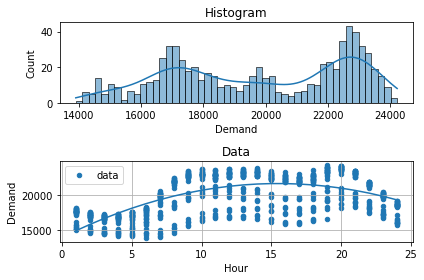

[-31.699156569241612, 980.9577410368405, 13984.774370230132]


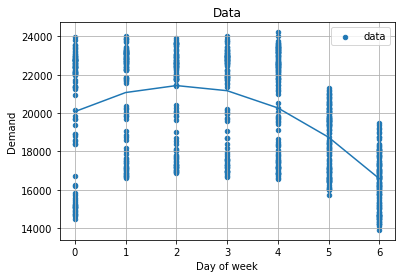

[-315.4445914817592, 1309.6339866197832, 20080.934521750652]


In [78]:
data = df_zapotrzebowanie[["Godzina", "Krajowe zapotrzebowanie na moc", "Dzień tygodnia"]]
ax = plt.subplot(2, 1, 1)
sns.histplot(data["Krajowe zapotrzebowanie na moc"], kde=True, ax=ax, bins=50)
plt.xlabel("Demand")
plt.title(f"Histogram")
x = data["Godzina"]
ax = plt.subplot(2, 1, 2)
data.plot(x="Godzina", y="Krajowe zapotrzebowanie na moc", kind="scatter", grid=True, label="data", ax=ax)
plt.title(f"Data")
plt.ylabel("Demand")
plt.xlabel("Hour")
coef = np.polyfit(x, data["Krajowe zapotrzebowanie na moc"], 2)  # Degree
p = np.poly1d(coef)
x = np.sort(x.drop_duplicates().to_numpy())
ax.plot(x, p(x), label="regression")
plt.tight_layout()
plt.show()
print(coef.tolist())
x = data["Dzień tygodnia"]
data.plot(x="Dzień tygodnia", y="Krajowe zapotrzebowanie na moc", kind="scatter", grid=True, label="data")
plt.title(f"Data")
plt.ylabel("Demand")
plt.xlabel("Day of week")
coef = np.polyfit(x, data["Krajowe zapotrzebowanie na moc"], 2)  # Degree
p = np.poly1d(coef)
x = np.sort(x.drop_duplicates().to_numpy())
plt.plot(x, p(x), label="regression")
plt.show()
print(coef.tolist())

### Prior

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing


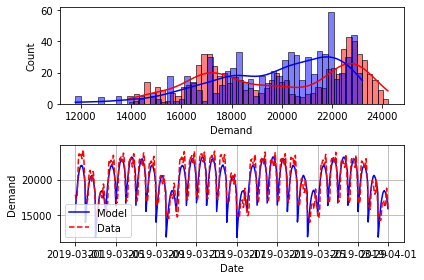

RMSE = 1354.1982249632665 / (max possible) 19982.844134824838


In [79]:
demand_ppc=CmdStanModel(stan_file='demand_ppc.stan')
demand = demand_ppc.sample(show_progress=False, data=dict(
    N=len(df_zapotrzebowanie), day_of_week=df_zapotrzebowanie["Dzień tygodnia"].values, 
    hour=df_zapotrzebowanie["Godzina"].values
    ))
df_demand = demand.draws_pd()
df_demand_mean = df_demand.mean()[[f"demand[{i}]" for i in range(1, len(df_zapotrzebowanie) + 1)]]
y_true = df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"]

ax = plt.subplot(2, 1, 1)
sns.histplot(y_true, kde=True, ax=ax, bins=50, color="r")
plt.xlabel("Demand")
sns.histplot(df_demand_mean, kde=True, ax=ax, bins=50, color="b")
plt.xlabel("Demand")
ax = plt.subplot(2, 1, 2)
ax.plot(df_zapotrzebowanie["Data_i_Godzina"], df_demand_mean, "b-",
         df_zapotrzebowanie["Data_i_Godzina"], y_true, "r--",)
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend(["Model", "Data"])
plt.grid(True)
plt.tight_layout()
plt.show()
print(f'RMSE = {mean_squared_error(y_true.values, df_demand_mean.values, squared=False)} / (max possible) '
      f'{mean_squared_error(y_true.values, np.zeros_like(y_true.values), squared=False)}')

In [ ]:
print(demand.summary())
parameters = ["a_day", "b_day", "a_hour", "b_hour", "offset_"]
N = len(parameters)
plt.figure(figsize=(13, 7))
for i in range(N):
    plt.subplot(3, 2, i + 1)
    sns.histplot(df_demand[parameters[i]], bins=50, kde=True)
plt.tight_layout()
plt.show()

### Posterior

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing


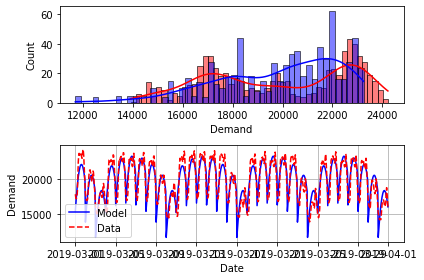

RMSE = 1348.75305399638 / (max possible) 19982.844134824838


In [80]:
demand_posterior=CmdStanModel(stan_file='demand_posterior.stan')
demand_post = demand_posterior.sample(show_progress=False, data=dict(
    N=len(df_zapotrzebowanie), day_of_week=df_zapotrzebowanie["Dzień tygodnia"].values, hour=df_zapotrzebowanie["Godzina"].values, 
    demand_samples=df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"].values
    ))
print(demand_post.diagnose())
df_demand_post = demand_post.draws_pd()
df_demand_post_mean = df_demand_post.mean()[[f"demand[{i}]" for i in range(1, len(df_zapotrzebowanie) + 1)]]
y_true = df_zapotrzebowanie["Krajowe zapotrzebowanie na moc"]

ax = plt.subplot(2, 1, 1)
sns.histplot(y_true, kde=True, ax=ax, bins=50, color="r")
plt.xlabel("Demand")
sns.histplot(df_demand_post_mean, kde=True, ax=ax, bins=50, color="b")
plt.xlabel("Demand")
ax = plt.subplot(2, 1, 2)
ax.plot(df_zapotrzebowanie["Data_i_Godzina"], df_demand_post_mean, "b-",
         df_zapotrzebowanie["Data_i_Godzina"], y_true, "r--",)
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend(["Model", "Data"])
plt.grid(True)
plt.tight_layout()
plt.show()
print(f'RMSE = {mean_squared_error(y_true.values, df_demand_post_mean.values, squared=False)} / (max possible) '
      f'{mean_squared_error(y_true.values, np.zeros_like(y_true.values), squared=False)}')

### Temperature's influence on the load

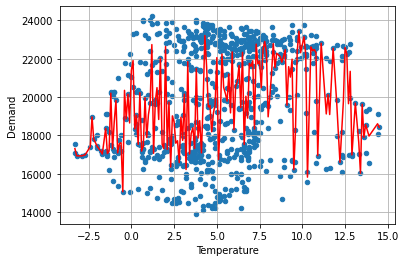

In [81]:
data = df_zapotrzebowanie[["Data_i_Godzina", "Godzina", "Krajowe zapotrzebowanie na moc"]]
# data = data[data["Godzina"].between(11, 21)]
data.insert(len(data.columns), "Temperatura", [
    round(df_naslonecznienie_marzec.loc[df_naslonecznienie_marzec["time"] == data.iloc[i]["Data_i_Godzina"]]["T2m"].values[0], 1) for i in range(len(data))
    ])
data.plot(x="Temperatura", y="Krajowe zapotrzebowanie na moc", kind="scatter", grid=True)
plt.plot(sorted(data["Temperatura"].unique()), data.groupby(["Temperatura"], sort=True).median()["Krajowe zapotrzebowanie na moc"], "r-")
plt.xlabel("Temperature")
plt.ylabel("Demand")
plt.show()

It seems that there is no influence of temperature on the demand, contrary to the project's assumptions.

## Generation

### Quadratic (wind speed) and linear (irradiance) regression

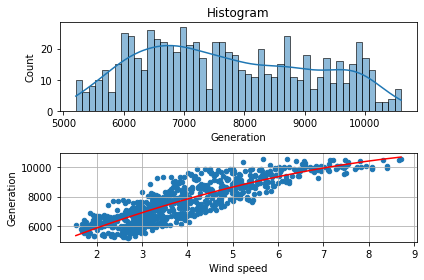

[ -56.4494838  1323.95434066 3449.06592958]


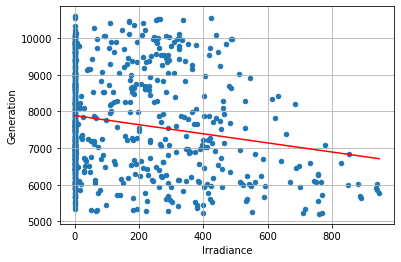

[-1.24182856e+00  7.88788242e+03]


In [82]:
data = df_zapotrzebowanie[["Data_i_Godzina", "Sumaryczna generacja nJWCD"]]
data.insert(len(data.columns), "Irradiance", [
    round(df_naslonecznienie_marzec.loc[df_naslonecznienie_marzec["time"] == data.iloc[i]["Data_i_Godzina"]]["G(i)"].values[0], 0) for i in range(len(data))
    ])
data.insert(len(data.columns), "Wind speed", [
    round(df_naslonecznienie_marzec.loc[df_naslonecznienie_marzec["time"] == data.iloc[i]["Data_i_Godzina"]]["WS10m"].values[0], 2) for i in range(len(data))
    ])
ax = plt.subplot(2, 1, 1)
sns.histplot(data["Sumaryczna generacja nJWCD"], kde=True, ax=ax, bins=50)
plt.xlabel("Generation")
plt.title(f"Histogram")
ax = plt.subplot(2, 1, 2)
x = data["Wind speed"]
data.plot(x="Wind speed", y="Sumaryczna generacja nJWCD", kind="scatter", grid=True, ax=ax)
coef_generation = np.polyfit(x, data["Sumaryczna generacja nJWCD"], 2)  # Degree
p = np.poly1d(coef_generation)
x = np.sort(x.drop_duplicates().to_numpy())
ax.plot(x, p(x), "r-")
plt.ylabel("Generation")
plt.tight_layout()
plt.show()
print(coef_generation)
x = data["Irradiance"]
data.plot(x="Irradiance", y="Sumaryczna generacja nJWCD", kind="scatter", grid=True)
coef_generation = np.polyfit(x, data["Sumaryczna generacja nJWCD"], 1)  # Degree
p = np.poly1d(coef_generation)
x = np.sort(x.drop_duplicates().to_numpy())
plt.plot(x, p(x), "r-")
plt.ylabel("Generation")
plt.show()
print(coef_generation)

For this model, irradiance will be ignored, to see if it is really any important influence.

### Prior

INFO:cmdstanpy:compiling stan file /home/ProjektDataAnalytics/Model_3_Fitting_to_histograms_without_irradiance/generation_ppc.stan to exe file /home/ProjektDataAnalytics/Model_3_Fitting_to_histograms_without_irradiance/generation_ppc
INFO:cmdstanpy:compiled model executable: /home/ProjektDataAnalytics/Model_3_Fitting_to_histograms_without_irradiance/generation_ppc
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [1] done processing


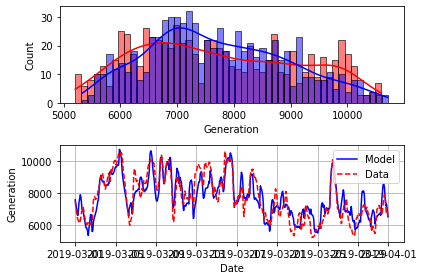

RMSE = 692.6044838312793 / (max possible) 7836.455433017564


In [83]:
generation_ppc=CmdStanModel(stan_file='generation_ppc.stan')
generation = generation_ppc.sample(show_progress=False, data=dict(
    N=len(data), wind_speed=data["Wind speed"].values
    ))
df_generation = generation.draws_pd()
df_generation_mean = df_generation.mean()[[f"generation[{i}]" for i in range(1, len(data) + 1)]]
y_true = data["Sumaryczna generacja nJWCD"]

ax = plt.subplot(2, 1, 1)
sns.histplot(y_true, kde=True, ax=ax, bins=50, color="r")
plt.xlabel("Generation")
sns.histplot(df_generation_mean, kde=True, ax=ax, bins=50, color="b")
plt.xlabel("Generation")
ax = plt.subplot(2, 1, 2)
ax.plot(data["Data_i_Godzina"], df_generation_mean, "b-",
        data["Data_i_Godzina"], y_true, "r--",)
plt.xlabel("Date")
plt.ylabel("Generation")
plt.legend(["Model", "Data"])
plt.grid(True)
plt.tight_layout()
plt.show()
print(f'RMSE = {mean_squared_error(y_true.values, df_generation_mean.values, squared=False)} '
      f'/ (max possible) {mean_squared_error(y_true.values, np.zeros_like(y_true.values), squared=False)}')

In [ ]:
print(generation.summary())
parameters = ["a_ws", "b_ws", "a_irr", "offset_"]
N = len(parameters)
plt.figure(figsize=(13, 7))
for i in range(N):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df_generation[parameters[i]], bins=50, kde=True)
plt.tight_layout()
plt.show()

### Posterior

INFO:cmdstanpy:compiling stan file /home/ProjektDataAnalytics/Model_3_Fitting_to_histograms_without_irradiance/generation_posterior.stan to exe file /home/ProjektDataAnalytics/Model_3_Fitting_to_histograms_without_irradiance/generation_posterior


INFO:cmdstanpy:compiled model executable: /home/ProjektDataAnalytics/Model_3_Fitting_to_histograms_without_irradiance/generation_posterior
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing


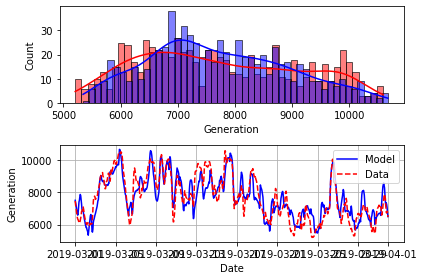

RMSE = 694.8258094511532 / (max possible) 7836.455433017564


In [84]:
y_true = data["Sumaryczna generacja nJWCD"]
generation_posterior=CmdStanModel(stan_file='generation_posterior.stan')
generation_post = generation_posterior.sample(show_progress=False, data=dict(
    N=len(data), wind_speed=data["Wind speed"].values, generation_samples=y_true.values
    ))
print(generation_post.diagnose())
df_generation_post = generation_post.draws_pd()
df_generation_post_mean = df_generation_post.mean()[[f"generation[{i}]" for i in range(1, len(y_true) + 1)]]

ax = plt.subplot(2, 1, 1)
sns.histplot(y_true, kde=True, ax=ax, bins=50, color="r")
plt.xlabel("Generation")
sns.histplot(df_generation_post_mean, kde=True, ax=ax, bins=50, color="b")
plt.xlabel("Generation")
ax = plt.subplot(2, 1, 2)
ax.plot(data["Data_i_Godzina"], df_generation_post_mean, "b-",
         data["Data_i_Godzina"], y_true, "r--",)
plt.xlabel("Date")
plt.ylabel("Generation")
plt.legend(["Model", "Data"])
plt.grid(True)
plt.tight_layout()
plt.show()
print(f'RMSE = {mean_squared_error(y_true.values, df_generation_post_mean.values, squared=False)} / (max possible) '
      f'{mean_squared_error(y_true.values, np.zeros_like(y_true.values), squared=False)}')

## Prices

### Determining the relation with Load and generation

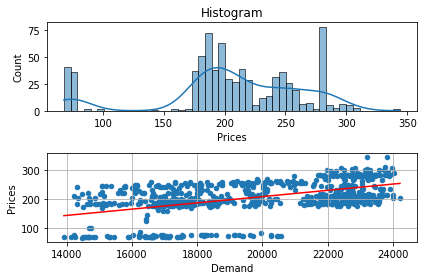

Coef demand [ 0.01070359 -5.34409143]
Coef generation [-7.16163456e-03  2.61603290e+02]


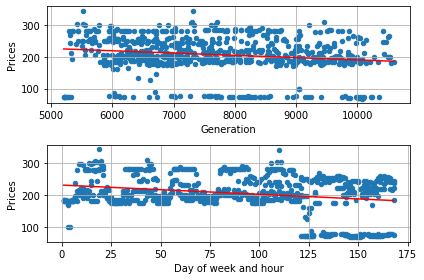

Coef time [ -0.2900096  232.20536388]


In [85]:
data = df_zapotrzebowanie.loc[:, ["Data_i_Godzina", "Sumaryczna generacja nJWCD", "Krajowe zapotrzebowanie na moc", "Godzina", "Dzień tygodnia"]]
data["Day_of_week_hour"] = data["Dzień tygodnia"] * 24 + data["Godzina"]
data.insert(len(data.columns), "Prices", [
    df_ceny.loc[df_ceny["Data_i_Godzina"] == data.iloc[i]["Data_i_Godzina"]]["CRO"].values[0] for i in range(len(data))
    ])
data["Residual load"] = data["Krajowe zapotrzebowanie na moc"] - data["Sumaryczna generacja nJWCD"]
ax = plt.subplot(2, 1, 1)
sns.histplot(data["Prices"], kde=True, ax=ax, bins=50)
plt.xlabel("Prices")
plt.title(f"Histogram")
ax = plt.subplot(2, 1, 2)
x = data["Krajowe zapotrzebowanie na moc"]
data.plot(x="Krajowe zapotrzebowanie na moc", y="Prices", kind="scatter", grid=True, ax=ax)
coef = np.polyfit(x, data["Prices"], 1)  # Degree
p = np.poly1d(coef)
x = np.sort(x.drop_duplicates().to_numpy())
ax.plot(x, p(x), "r-")
plt.ylabel("Prices")
plt.xlabel("Demand")
plt.tight_layout()
plt.show()
print(f"Coef demand {coef}")
ax = plt.subplot(2, 1, 1)
x = data["Sumaryczna generacja nJWCD"]
data.plot(x="Sumaryczna generacja nJWCD", y="Prices", kind="scatter", grid=True, ax=ax)
coef = np.polyfit(x, data["Prices"], 1)  # Degree
p = np.poly1d(coef)
x = np.sort(x.drop_duplicates().to_numpy())
ax.plot(x, p(x), "r-")
plt.ylabel("Prices")
plt.xlabel("Generation")
print(f"Coef generation {coef}")
ax = plt.subplot(2, 1, 2)
x = data["Day_of_week_hour"]
data.plot(x="Day_of_week_hour", y="Prices", kind="scatter", grid=True, ax=ax)
coef = np.polyfit(x, data["Prices"], 1)  # Degree
p = np.poly1d(coef)
x = np.sort(x.drop_duplicates().to_numpy())
ax.plot(x, p(x), "r-")
plt.ylabel("Prices")
plt.xlabel("Day of week and hour")
plt.tight_layout()
plt.show()
print(f"Coef time {coef}")

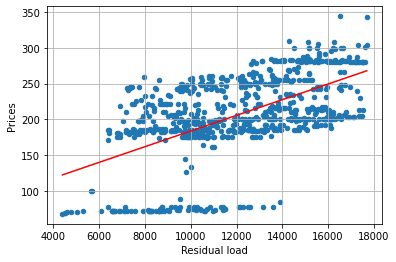

[1.09332625e-02 7.44274576e+01]


In [86]:
x = data["Residual load"]
data.plot(x="Residual load", y="Prices", kind="scatter", grid=True)
coef_prices = np.polyfit(x, data["Prices"], 1)  # Degree
p = np.poly1d(coef_prices)
x = np.sort(x.drop_duplicates().to_numpy())
plt.plot(x, p(x), "r-")
plt.show()
print(coef_prices)

### Prior

INFO:cmdstanpy:compiling stan file /home/ProjektDataAnalytics/Model_3_Fitting_to_histograms_without_irradiance/prices_ppc.stan to exe file /home/ProjektDataAnalytics/Model_3_Fitting_to_histograms_without_irradiance/prices_ppc
INFO:cmdstanpy:compiled model executable: /home/ProjektDataAnalytics/Model_3_Fitting_to_histograms_without_irradiance/prices_ppc
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing


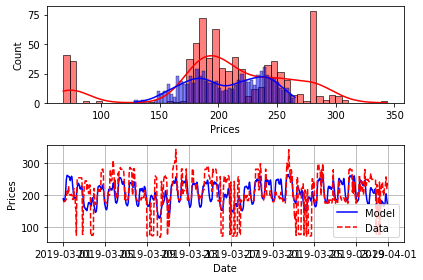

RMSE = 48.10751983121474 / (max possible) 214.47741087247994


In [87]:
y_true = data["Prices"]
prices_ppc=CmdStanModel(stan_file='prices_ppc.stan')
prices = prices_ppc.sample(show_progress=False, data=dict(
    N=len(data), demand=data["Krajowe zapotrzebowanie na moc"], generation=data["Sumaryczna generacja nJWCD"]
    ))
df_prices = prices.draws_pd()
df_prices_mean = df_prices.mean()[[f"prices[{i}]" for i in range(1, len(data) + 1)]]

ax = plt.subplot(2, 1, 1)
sns.histplot(y_true, kde=True, ax=ax, bins=50, color="r")
plt.xlabel("Prices")
sns.histplot(df_prices_mean, kde=True, ax=ax, bins=50, color="b")
plt.xlabel("Prices")
ax = plt.subplot(2, 1, 2)
ax.plot(data["Data_i_Godzina"], df_prices_mean, "b-",
        data["Data_i_Godzina"], y_true, "r--",)
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend(["Model", "Data"])
plt.grid(True)
plt.tight_layout()
plt.show()
print(f'RMSE = {mean_squared_error(y_true.values, df_prices_mean.values, squared=False)} '
      f'/ (max possible) {mean_squared_error(y_true.values, np.zeros_like(y_true.values), squared=False)}')

In [ ]:
print(prices.summary())
parameters = ["a_demand", "a_generation", "offset_"]
N = len(parameters)
plt.figure(figsize=(13, 7))
for i in range(N):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df_prices[parameters[i]], bins=50, kde=True)
plt.tight_layout()
plt.show()

### Posterior

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing


INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing


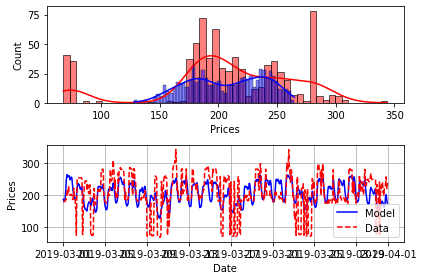

RMSE = 48.086924030695805 / (max possible) 214.47741087247994


In [88]:
y_true = data["Prices"]
prices_posterior=CmdStanModel(stan_file='prices_posterior.stan')
prices_post = prices_posterior.sample(show_progress=False, data=dict(
    N=len(data), demand=data["Krajowe zapotrzebowanie na moc"], generation=data["Sumaryczna generacja nJWCD"], prices_samples=y_true.values
    ))
print(prices_post.diagnose())
df_prices_post = prices_post.draws_pd()
df_prices_post_mean = df_prices_post.mean()[[f"prices[{i}]" for i in range(1, len(data) + 1)]]

ax = plt.subplot(2, 1, 1)
sns.histplot(y_true, kde=True, ax=ax, bins=50, color="r")
plt.xlabel("Prices")
sns.histplot(df_prices_post_mean, kde=True, ax=ax, bins=50, color="b")
plt.xlabel("Prices")
ax = plt.subplot(2, 1, 2)
ax.plot(data["Data_i_Godzina"], df_prices_post_mean, "b-",
        data["Data_i_Godzina"], y_true, "r--",)
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend(["Model", "Data"])
plt.grid(True)
plt.tight_layout()
plt.show()
print(f'RMSE = {mean_squared_error(y_true.values, df_prices_post_mean.values, squared=False)} '
      f'/ (max possible) {mean_squared_error(y_true.values, np.zeros_like(y_true.values), squared=False)}')

## Overall posterior

INFO:cmdstanpy:compiling stan file /home/ProjektDataAnalytics/Model_3_Fitting_to_histograms_without_irradiance/final_posterior.stan to exe file /home/ProjektDataAnalytics/Model_3_Fitting_to_histograms_without_irradiance/final_posterior
INFO:cmdstanpy:compiled model executable: /home/ProjektDataAnalytics/Model_3_Fitting_to_histograms_without_irradiance/final_posterior
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing


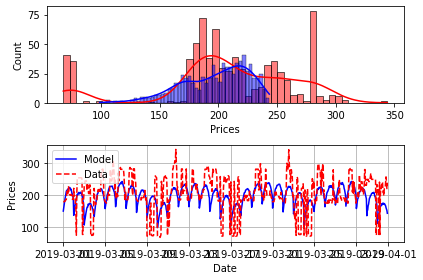

RMSE = 53.26921584013232 / (max possible) 214.47741087247994


In [89]:
data = df_zapotrzebowanie[["Godzina", "Data_i_Godzina", "Dzień tygodnia"]]
data.insert(len(data.columns), "Wind speed", [
    round(df_naslonecznienie_marzec.loc[df_naslonecznienie_marzec["time"] == data.iloc[i]["Data_i_Godzina"]]["WS10m"].values[0], 2) for i in range(len(data))
    ])
data.insert(len(data.columns), "Prices", [
    df_ceny.loc[df_ceny["Data_i_Godzina"] == data.iloc[i]["Data_i_Godzina"]]["CRO"].values[0] for i in range(len(data))
    ])
y_true = data["Prices"]
final_posterior=CmdStanModel(stan_file='final_posterior.stan')
predictions = final_posterior.sample(show_progress=False, data=dict(
    N_samples=len(data), day_of_week_historic=data["Dzień tygodnia"], hour_historic=data["Godzina"], wind_speed_historic=data["Wind speed"], 
    prices_samples=data["Prices"],
    N=len(data), day_of_week=data["Dzień tygodnia"], hour=data["Godzina"], wind_speed=data["Wind speed"]
    ))
print(predictions.diagnose())
df_predictions = predictions.draws_pd()
y_pred = df_predictions.mean()[[f"prices[{i}]" for i in range(1, len(data) + 1)]]

ax = plt.subplot(2, 1, 1)
sns.histplot(y_true, kde=True, ax=ax, bins=50, color="r")
plt.xlabel("Prices")
sns.histplot(y_pred, kde=True, ax=ax, bins=50, color="b")
plt.xlabel("Prices")
ax = plt.subplot(2, 1, 2)
ax.plot(data["Data_i_Godzina"], y_pred, "b-",
        data["Data_i_Godzina"], y_true, "r--",)
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend(["Model", "Data"])
plt.grid(True)
plt.tight_layout()
plt.show()
print(f'RMSE = {mean_squared_error(y_true.values, y_pred.values, squared=False)} '
      f'/ (max possible) {mean_squared_error(y_true.values, np.zeros_like(y_true.values), squared=False)}')